<a href="https://colab.research.google.com/github/MichalRozenwald/epiCausality/blob/main/modeling_bcells_Pangenomes_Misha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!mkdir Data

In [2]:
! unzip /content/Data/bindata_samples-20240511T173500Z-001.zip

Archive:  /content/Data/bindata_samples-20240511T173500Z-001.zip
  inflating: bindata_samples/sim_408A.csv  
  inflating: bindata_samples/sim_408.csv  
  inflating: bindata_samples/sim_597.csv  
  inflating: bindata_samples/sim_408B.csv  
  inflating: bindata_samples/sim_published.csv  


In [4]:
! unzip /content/Data/neighbor_samples-20240511T173503Z-001.zip

Archive:  /content/Data/neighbor_samples-20240511T173503Z-001.zip
  inflating: neighbor_samples/sim_408B.csv  
  inflating: neighbor_samples/sim_597.csv  
  inflating: neighbor_samples/sim_408.csv  
  inflating: neighbor_samples/sim_published.csv  
  inflating: neighbor_samples/sim_408A.csv  


> mv both unziped  folders into the Data foldes

In [5]:
from os.path import join
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

path = join("Data")
sim1all = pd.read_csv(join(path, "bindata_samples", "sim_597.csv"))
sim1neigh = pd.read_csv(join(path, "neighbor_samples", "sim_597.csv"))

sim2allA = pd.read_csv(join(path, "bindata_samples", "sim_408A.csv"))
sim2neighA = pd.read_csv(join(path, "neighbor_samples", "sim_408A.csv"))
sim2allB = pd.read_csv(join(path, "bindata_samples", "sim_408B.csv"))
sim2neighB = pd.read_csv(join(path, "neighbor_samples", "sim_408B.csv"))
half = sim2neighA.shape[0]//2
sim2allF = pd.concat([sim2allA[:half], sim2allB[half:]], axis=0)
sim2neighF = pd.concat([sim2neighA[:half], sim2neighB[half:]], axis=0)


In [6]:
# Class 1 is 597, class 0 is 408
N1, N2 = sim1all.shape[0], sim2allF.shape[0]
# X = np.concatenate((sim1all, sim2allF))
X = np.concatenate((sim1neigh, sim2neighF))
Y = np.concatenate((np.ones(N1), np.zeros(N2)))

train_idx, test_idx = train_test_split(np.arange(N1+N2), train_size=.75,random_state=42)
X_train, X_test = X[train_idx], X[test_idx]
Y_train, Y_test = Y[train_idx], Y[test_idx]


In [7]:
Y_train.shape, Y_test.shape

((150000,), (50000,))

In [8]:
X_train.shape, X_test.shape

((150000, 10), (50000, 10))

- neighbor sampling (better): 77% on all models (NN, RF, GBM, CART). was only 70% on GLM
- bindata sampling: ~70% on all models

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
def predict(f, X, Y):
    return np.mean(f.predict(X)==Y)

model = LogisticRegression().fit(X_train,Y_train)
print("GLM: {:.2f}".format(predict(model, X_test, Y_test)))

print("####")
model = DecisionTreeClassifier().fit(X_train,Y_train)
print("Tree: {:.2f}".format(predict(model, X_test, Y_test)))

print("####")
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(15,)).fit(X_train, Y_train)
print("NN: {:.2f}".format(predict(model, X_test, Y_test)))
# model = SVC().fit(X_train,Y_train)
# print(np.mean(model.predict(X_test)==Y_test))
print("####")
model = RandomForestClassifier().fit(X_train,Y_train)
print("RF: {:.2f}".format(predict(model, X_test, Y_test)))
print("####")
model = GradientBoostingClassifier().fit(X_train,Y_train)
print("GBM: {:.2f}".format(predict(model, X_test, Y_test)))



GLM: 0.70
####
Tree: 0.77
####
NN: 0.77
####
RF: 0.77
####
GBM: 0.77


Epoch 1/10
4688/4688 [==============================] - 14s 3ms/step - loss: 0.1617 - val_loss: 0.1552
Epoch 2/10
4688/4688 [==============================] - 15s 3ms/step - loss: 0.1569 - val_loss: 0.1557
Epoch 3/10
4688/4688 [==============================] - 13s 3ms/step - loss: 0.1560 - val_loss: 0.1544
Epoch 4/10
4688/4688 [==============================] - 16s 3ms/step - loss: 0.1554 - val_loss: 0.1535
Epoch 5/10
4688/4688 [==============================] - 13s 3ms/step - loss: 0.1552 - val_loss: 0.1557
Epoch 6/10
4688/4688 [==============================] - 13s 3ms/step - loss: 0.1549 - val_loss: 0.1539
Epoch 7/10
4688/4688 [==============================] - 15s 3ms/step - loss: 0.1548 - val_loss: 0.1543
Epoch 8/10
4688/4688 [==============================] - 13s 3ms/step - loss: 0.1548 - val_loss: 0.1537
Epoch 9/10
4688/4688 [==============================] - 15s 3ms/step - loss: 0.1547 - val_loss: 0.1533
Epoch 10/10
4688/4688 [==============================] - 14s 3ms/step - l

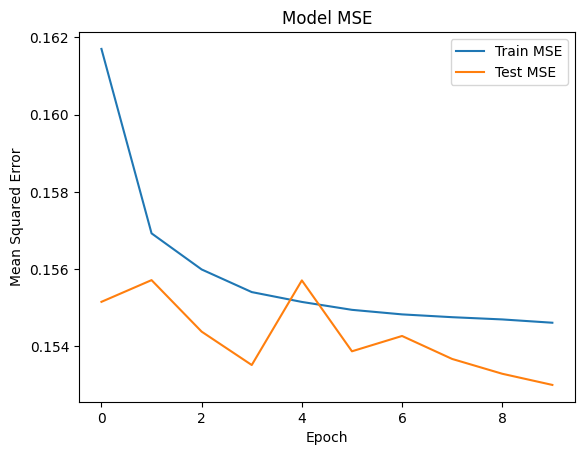

1563/1563 [==============================] - 2s 1ms/step
1D CNN: 50.21%


In [10]:
x_train, x_test = X_train, X_test
y_train, y_test = Y_train, Y_test


import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.model_selection import train_test_split

# # Create dummy data
# x = np.random.rand(1200, 10, 1)
# y = np.random.rand(1200) * 100


# # Split the data into training and test sets
# X_train, X_test => x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Build the 1D CNN model
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(10, 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model and save history
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Test MSE')
plt.title('Model MSE')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


def predict_reg(f, X, Y):
    preds = f.predict(X)
    preds012 = np.round(preds / 50) # 100-->2; 50-->1; 0-->0
    return np.mean(preds012*50==Y)*100

print("1D CNN: {:.2f}%".format(predict_reg(model, x_test, y_test)))


In [13]:
# history

In [15]:
# Train mode
n_epochs = 3

# Train the model and save history
history_next = model.fit(x_train, y_train, epochs=n_epochs, batch_size=32, validation_data=(x_test, y_test))


Epoch 1/3
4688/4688 [==============================] - 26s 6ms/step - loss: 0.1545 - val_loss: 0.1536
Epoch 2/3
4688/4688 [==============================] - 13s 3ms/step - loss: 0.1545 - val_loss: 0.1532
Epoch 3/3
4688/4688 [==============================] - 13s 3ms/step - loss: 0.1544 - val_loss: 0.1539


In [16]:

# Train the model and save history
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test))

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Test MSE')
plt.title('Model MSE')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


def predict_reg(f, X, Y):
    preds = f.predict(X)
    preds012 = np.round(preds / 50) # 100-->2; 50-->1; 0-->0
    return np.mean(preds012*50==Y)*100

print("1D CNN: {:.2f}%".format(predict_reg(model, x_test, y_test)))


Epoch 1/100
4688/4688 [==============================] - 16s 4ms/step - loss: 0.1544 - val_loss: 0.1533
Epoch 2/100
4688/4688 [==============================] - 16s 3ms/step - loss: 0.1544 - val_loss: 0.1529
Epoch 3/100
4688/4688 [==============================] - 13s 3ms/step - loss: 0.1543 - val_loss: 0.1530
Epoch 4/100
4688/4688 [==============================] - 13s 3ms/step - loss: 0.1544 - val_loss: 0.1536
Epoch 5/100
4688/4688 [==============================] - 14s 3ms/step - loss: 0.1543 - val_loss: 0.1533
Epoch 6/100
4688/4688 [==============================] - 13s 3ms/step - loss: 0.1543 - val_loss: 0.1531
Epoch 7/100
4688/4688 [==============================] - 14s 3ms/step - loss: 0.1543 - val_loss: 0.1531
Epoch 8/100
4688/4688 [==============================] - 14s 3ms/step - loss: 0.1542 - val_loss: 0.1534
Epoch 9/100
4688/4688 [==============================] - 14s 3ms/step - loss: 0.1542 - val_loss: 0.1531
Epoch 10/100
4688/4688 [==============================] - 14s 3m

KeyboardInterrupt: 

In [17]:
print("1D CNN: {:.2f}%".format(predict_reg(model, x_test, y_test)))


1563/1563 [==============================] - 5s 3ms/step
1D CNN: 50.21%


In [18]:
# # Train mode
# n_epochs = 3

# # Train the model and save history
# # history_next = model.fit(x_train, y_train, epochs=n_epochs, batch_size=32, validation_data=(x_test, y_test)))

# history.history['loss'].append(history_next.history['loss']) #, label='Train MSE')
# history.history['val_loss'].append(history_next.history['val_loss'])

# # Plot the training and validation loss
# plt.plot(history.history['loss'], label='Train MSE')
# plt.plot(history.history['val_loss'], label='Test MSE')
# plt.title('Model MSE')
# plt.ylabel('Mean Squared Error')
# plt.xlabel('Epoch')
# plt.legend(loc='upper right')
# plt.show()


# def predict_reg(f, X, Y):
#     preds = f.predict(X)
#     preds012 = np.round(preds / 50) # 100-->2; 50-->1; 0-->0
#     return np.mean(preds012*50==Y)*100

# print("1D CNN: {:.2f}%".format(predict_reg(model, x_test, y_test)))
